In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
# int8: -128~127
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
#transform = transforms.Compose([transforms.ToTensor(),])

In [4]:
trainset = datasets.MNIST('./trainset', download=True, train=True, transform=transform)
#trainset = datasets.MNIST('./trainset', download=True, train=True)

valset = datasets.MNIST('./testset', download=True, train=False, transform=transform)
#valset = datasets.MNIST('./testset', download=True, train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [17]:
print(trainset)
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = transforms.functional.convert_image_dtype(images, torch.int8)
#print(type(dataiter))
#for p in dataiter:
#    print(p)

print(images.shape)
print(labels.shape)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./trainset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
torch.Size([64, 1, 28, 28])
torch.Size([64])


array([[[-127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127],
        [-127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127],
        [-127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127],
        [-127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127],
        [-127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
         -127, -127, -127, -127, -127, -127, -127, -127],
        [-127, -127,

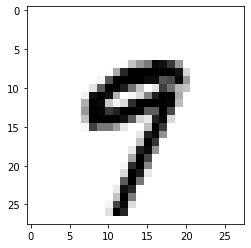

In [18]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
images[0].numpy()

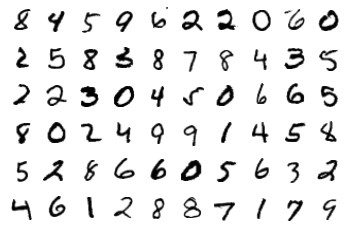

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [20]:
import os
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

if os.path.isfile("./mnist_model.pt"):
    model.load_state_dict(torch.load("./mnist_model.pt"))
    print("Load complete")
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)


In [21]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [22]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0037, -0.0037, -0.0037,  ..., -0.0037, -0.0037, -0.0037],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        ...,
        [-0.0051, -0.0051, -0.0051,  ..., -0.0051, -0.0051, -0.0051],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003]])


In [23]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 100
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5394782720566559
Epoch 1 - Training loss: 0.3237201946853066
Epoch 2 - Training loss: 0.30912355892757365
Epoch 3 - Training loss: 0.30031956650856845
Epoch 4 - Training loss: 0.2932115369943032
Epoch 5 - Training loss: 0.2898998785414485
Epoch 6 - Training loss: 0.2874450221228828
Epoch 7 - Training loss: 0.28377033287146963
Epoch 8 - Training loss: 0.2816474545500807
Epoch 9 - Training loss: 0.2789551389973555
Epoch 10 - Training loss: 0.27659415160573875
Epoch 11 - Training loss: 0.2754494907266931
Epoch 12 - Training loss: 0.2741854814276385
Epoch 13 - Training loss: 0.272938540769316
Epoch 14 - Training loss: 0.2733976673851135
Epoch 15 - Training loss: 0.27076102663744994
Epoch 16 - Training loss: 0.2704350305423299
Epoch 17 - Training loss: 0.2699379144049784
Epoch 18 - Training loss: 0.2670389622497533
Epoch 19 - Training loss: 0.2676048600343245
Epoch 20 - Training loss: 0.26741635837137445
Epoch 21 - Training loss: 0.2636963489141736
Epoch 22 - Trai

KeyboardInterrupt: ignored

Predicted Digit = 4
<class 'torch.Tensor'>


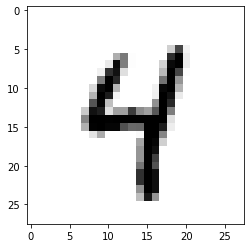

In [24]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print(type(img.view(1, 28, 28)))
plt.imshow(img.view(1, 28, 28).numpy().squeeze(), cmap='gray_r');

In [25]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9211


In [26]:
torch.save(model.state_dict(), "./mnist_model.pt")

In [27]:
# Quantization
model_int8 = torch.quantization.quantize_dynamic(
    model,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [28]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model_int8(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9211


In [29]:
model_int8
torch.save(model_int8.state_dict(), "./mnist_model_int8.pt")

In [30]:
from torchsummary import summary

summary(model, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2                [-1, 1, 64]           8,256
            Linear-3                [-1, 1, 10]             650
        LogSoftmax-4                [-1, 1, 10]               0
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


Numpy Test

In [ ]:
import os

weight_dir = os.path("./weights")
